Load the MNIST training data and scale it between 0 and 1.

In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt


(train_x, train_y), (test_x, test_y) = utils.processed_data()

Train a neural network with a single convolutional layer.

In [2]:
import os
import keras
import keras.layers as layers
import keras.models as models
import keras.backend as K
from model import LogGaussMF


def train_model():
    model = keras.Sequential([
        layers.Reshape((28,28,1), input_shape=(28,28)),
        layers.Conv2D(16, 3, strides=1, activation="relu", padding="same"),
        layers.Flatten(),
        LogGaussMF(10),
        layers.Lambda(lambda x: K.sum(x, axis=-1)),
        layers.Lambda(lambda x: K.exp(x - K.max(x, axis=-1, keepdims=True))),
        layers.Dense(10),
        layers.Activation("softmax")
    ])
    
    model.compile(
        optimizer=keras.optimizers.adam(lr=0.0005),
        loss="binary_crossentropy",
        metrics=[keras.metrics.categorical_accuracy])

    # train the model
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=64,
        epochs=20,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True)

    return model


if not os.path.exists("saved_models/"):
    os.makedirs("saved_models/")
    
if not os.path.exists("saved_models/rp_conv1_model.h5"):
    model = train_model()
    model.save("saved_models/rp_conv1_model.h5")
else:
    print("Loading saved model...", end=" ")
    model = keras.models.load_model(
    "saved_models/rp_conv1_model.h5",
    custom_objects={
        "LogGaussMF": lambda **x: LogGaussMF(rules=10, **x),
    })
    print("done.")

Using TensorFlow backend.


Loading saved model... 

W0328 12:36:29.753904 140333910497088 deprecation.py:323] From /home/ryan-desktop/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


done.


Find the representatives of each class (the training samples that maximize the activation of each logit).

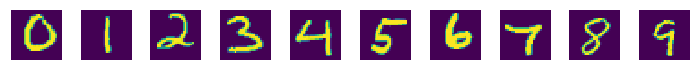

In [3]:
def find_representatives(model):
    pred_y = model.predict(train_x)
    
    repr_idxs = []
    for i in range(10):
        repr_idxs.append(np.argmax(pred_y[:,i]))
    
    return train_x[repr_idxs]


representatives = find_representatives(model)

fig, axes = plt.subplots(1, 10, figsize=(10,1))
for i, image in enumerate(representatives):
    axes[i].imshow(image)
    
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

Write a method to analyze each representative and propagate the fuzzy rules back to the input dimension. Some changes had to be made to the procedure discussed in order to ensure good results were achieved.

The new procedure:
1. Find the max value of the logits.
2. Find the fuzzy rule with the largest contribution to this logit.
    * The contribrution is calculated as the weight times the firing strength of the rule.
3. Find the membership function with the largest contribution to the fuzzy rule.
    * The membership function with the highest value is not a good indicator of contribution. Thousands of memberships shared the same highest value and the MF selected was not usually in an area with relevant data.
    * The contribution of each membership function is calculated as the membership value times the input data.
    * This ensures the MF with the largest contribution is not on the out edge of the image.
4. Use guided backprop from the neuron corresponding with the most relevant MF.

This method is only assigns relevance to a 3x3 area in the input dimension. This is because each neuron in the flatten layer is only connected to a 3x3 patch of pixels in the input space. This area would increase with stacked convolutions or larger convolutions. Later in the notebook this procedure is modified to find more relevant pixels.

Max Logit:
Value = 8.30, Index = 0

Most Important Rule:
Value = 4.27, Index = 4

Most Important Membership Function:
Value = 0.61, Index = 2974



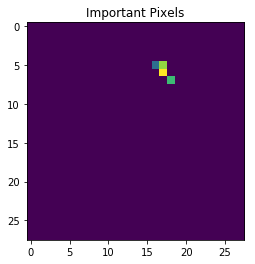

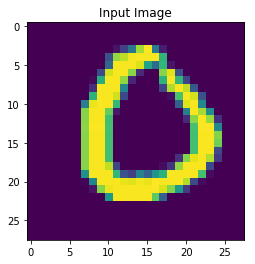

In [4]:
import innvestigate
from keras.models import Model


def analyze_representative(model, representative):
    assert(isinstance(model.layers[-6], layers.Flatten))
    assert(isinstance(model.layers[-5], LogGaussMF))
    assert(isinstance(model.layers[-4], layers.Lambda))
    assert(isinstance(model.layers[-3], layers.Lambda))
    assert(isinstance(model.layers[-2], layers.Dense))
    
    # outputs needed for analyzing the network
    features_tensor = model.layers[-6].output
    memberships_tensor = model.layers[-5].output
    firing_strength_tensor = model.layers[-3].output
    logits_tensor = model.layers[-2].output
    
    # new model with the outputs from above
    analysis_model = Model(model.inputs, [
        features_tensor,
        memberships_tensor,
        firing_strength_tensor,
        logits_tensor,
    ])
    
    # compute the values of those tensors on the representative
    features, memberships, firing_strength, logits = analysis_model.predict(
        representative.reshape(1, 28, 28))
    
    # find and output the max logit
    logit_val, logit_idx = np.max(logits), np.argmax(logits)
    print("Max Logit:")
    print("Value = {:.2f}, Index = {}\n".format(logit_val, logit_idx))
    
    # find the rule that contributed most to the logit
    # this is computed as firing strength multiplied by the weights
    W = analysis_model.layers[-1].get_weights()[0]
    R = W[:,logit_idx] * firing_strength
    rule_val, rule_idx = np.max(R), np.argmax(R)
    print("Most Important Rule:")
    print("Value = {:.2f}, Index = {}\n".format(rule_val, rule_idx))
    
    # most relevant membership functions
    R = np.exp(memberships[:,rule_idx,:]) * features
    membership_val = np.max(R)
    membership_idx = np.argmax(R)
    print("Most Important Membership Function:")
    print("Value = {:.2f}, Index = {}\n".format(membership_val, membership_idx))
    
    model_wo_softmax = Model(model.inputs, [model.layers[-6].output])
    analyzer = innvestigate.create_analyzer(
        "guided_backprop", 
        model_wo_softmax,
        neuron_selection_mode="index",
        allow_lambda_layers=True)
    
    analysis = analyzer.analyze(
        representative.reshape(1, 28, 28),
        membership_idx).squeeze()
    
    cutoff = np.percentile(analysis.flatten(), 95)
    analysis *= (analysis >= cutoff)
    
    plt.imshow(analysis)
    plt.title("Important Pixels")
    
    plt.figure()
    plt.imshow(representative)
    plt.title("Input Image")
    

analyze_representative(model, representatives[0])

Max Logit:
Value = 6.06, Index = 1

Most Important Rule:
Value = 3.87, Index = 2

Most Important Membership Function:
Value = 0.56, Index = 10529



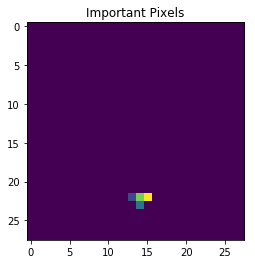

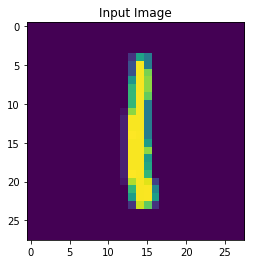

In [5]:
analyze_representative(model, representatives[1])

Max Logit:
Value = 8.41, Index = 2

Most Important Rule:
Value = 3.29, Index = 5

Most Important Membership Function:
Value = 0.65, Index = 9249



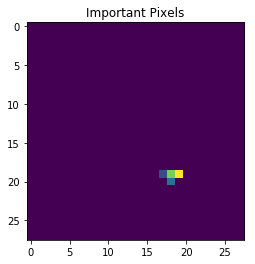

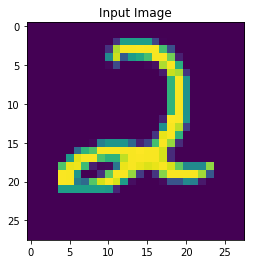

In [6]:
analyze_representative(model, representatives[2])

Max Logit:
Value = 9.42, Index = 3

Most Important Rule:
Value = 2.63, Index = 7

Most Important Membership Function:
Value = 0.60, Index = 6945



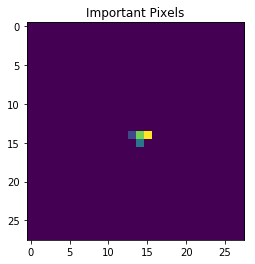

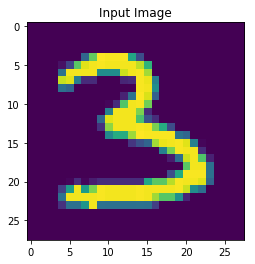

In [7]:
analyze_representative(model, representatives[3])

Max Logit:
Value = 7.03, Index = 4

Most Important Rule:
Value = 4.55, Index = 3

Most Important Membership Function:
Value = 0.64, Index = 7441



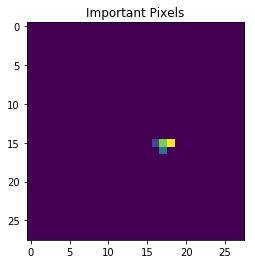

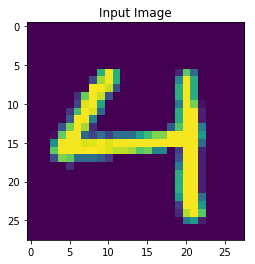

In [8]:
analyze_representative(model, representatives[4])

Max Logit:
Value = 7.74, Index = 5

Most Important Rule:
Value = 3.36, Index = 0

Most Important Membership Function:
Value = 0.63, Index = 4273



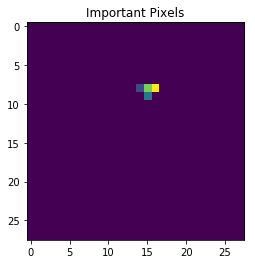

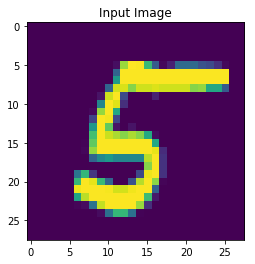

In [9]:
analyze_representative(model, representatives[5])

Max Logit:
Value = 8.32, Index = 6

Most Important Rule:
Value = 3.04, Index = 1

Most Important Membership Function:
Value = 0.63, Index = 10081



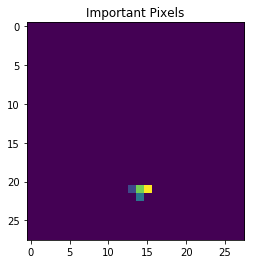

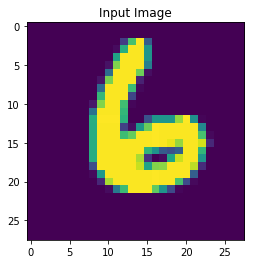

In [10]:
analyze_representative(model, representatives[6])

Max Logit:
Value = 8.80, Index = 7

Most Important Rule:
Value = 2.71, Index = 4

Most Important Membership Function:
Value = 0.63, Index = 5969



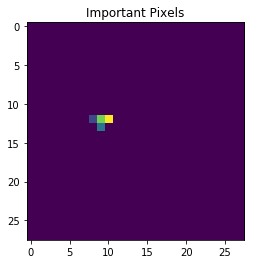

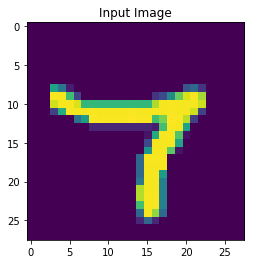

In [11]:
analyze_representative(model, representatives[7])

Max Logit:
Value = 8.08, Index = 8

Most Important Rule:
Value = 3.27, Index = 1

Most Important Membership Function:
Value = 0.68, Index = 6111



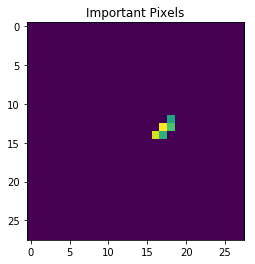

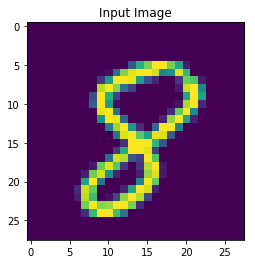

In [12]:
analyze_representative(model, representatives[8])

Max Logit:
Value = 7.12, Index = 9

Most Important Rule:
Value = 2.90, Index = 2

Most Important Membership Function:
Value = 0.65, Index = 3415



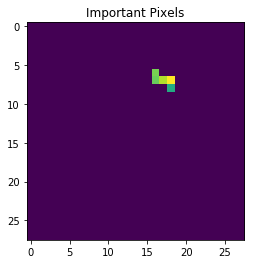

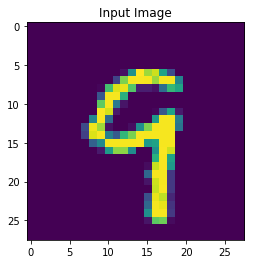

In [13]:
analyze_representative(model, representatives[9])

This function implements a modifed procedure that allows for relevance values to be propagated back over more of the image. Rather than selecting the membership function with the largest contribution, the top k membership functions are propagated back to the input space, giving a more complete picture of the relevant pixels. For the exmaples below, k is set to 10.

Max Logit:
Value = 8.30, Index = 0

Most Important Rule:
Value = 4.27, Index = 4

Most Important Membership Functions:
Value = 0.61, Index = 2974
Value = 0.61, Index = 2526
Value = 0.57, Index = 10529
Value = 0.56, Index = 3902
Value = 0.56, Index = 3438
Value = 0.56, Index = 5278
Value = 0.56, Index = 1580
Value = 0.56, Index = 3895
Value = 0.56, Index = 1596
Value = 0.55, Index = 10497



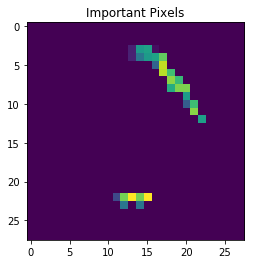

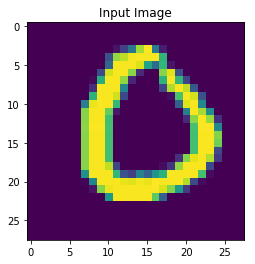

In [14]:
def analyze_representative_v2(model, representative, top_k=10):
    assert(isinstance(model.layers[-6], layers.Flatten))
    assert(isinstance(model.layers[-5], LogGaussMF))
    assert(isinstance(model.layers[-4], layers.Lambda))
    assert(isinstance(model.layers[-3], layers.Lambda))
    assert(isinstance(model.layers[-2], layers.Dense))
    
    # outputs needed for analyzing the network
    features_tensor = model.layers[-6].output
    memberships_tensor = model.layers[-5].output
    firing_strength_tensor = model.layers[-3].output
    logits_tensor = model.layers[-2].output
    
    # new model with the outputs from above
    analysis_model = Model(model.inputs, [
        features_tensor,
        memberships_tensor,
        firing_strength_tensor,
        logits_tensor,
    ])
    
    # compute the values of those tensors on the representative
    features, memberships, firing_strength, logits = analysis_model.predict(
        representative.reshape(1, 28, 28))
    
    # find and output the max logit
    logit_val, logit_idx = np.max(logits), np.argmax(logits)
    print("Max Logit:")
    print("Value = {:.2f}, Index = {}\n".format(logit_val, logit_idx))
    
    # find the rule that contributed most to the logit
    # this is computed as firing strength multiplied by the weights
    W = analysis_model.layers[-1].get_weights()[0]
    R = W[:,logit_idx] * firing_strength
    rule_val, rule_idx = np.max(R), np.argmax(R)
    print("Most Important Rule:")
    print("Value = {:.2f}, Index = {}\n".format(rule_val, rule_idx))
    
    # the maximum membership value does not appear to be a good indicator of the
    # most important membership function. a large number of rules seem to share
    # the maximum possible value of the membership function, 1.
    mu, beta = analysis_model.layers[-4].get_weights()
    R = np.exp(memberships[:,rule_idx,:]) * features
    print("Most Important Membership Functions:")
    
    analysis = np.zeros((28, 28), np.float32)
    
    for i in range(top_k):
        membership_val = np.max(R)
        membership_idx = np.argmax(R)
        print("Value = {:.2f}, Index = {}".format(membership_val, membership_idx))
        
        # zero the relevance value so that a new neuron is selected next time.
        R[0, membership_idx] = 0

        model_wo_softmax = Model(model.inputs, [model.layers[-6].output])
        analyzer = innvestigate.create_analyzer(
            "guided_backprop", 
            model_wo_softmax,
            neuron_selection_mode="index",
            allow_lambda_layers=True)

        a = analyzer.analyze(
            representative.reshape(1, 28, 28),
            membership_idx).squeeze()
        
        analysis = np.maximum(analysis, a)
    
        cutoff = np.percentile(analysis.flatten(), 95)
        analysis *= (analysis >= cutoff)
        
    # newline
    print()
    
    plt.imshow(analysis)
    plt.title("Important Pixels")
    
    plt.figure()
    plt.imshow(representative)
    plt.title("Input Image")
    

analyze_representative_v2(model, representatives[0])

Max Logit:
Value = 6.06, Index = 1

Most Important Rule:
Value = 3.87, Index = 2

Most Important Membership Functions:
Value = 0.56, Index = 10529
Value = 0.55, Index = 6069
Value = 0.54, Index = 5621
Value = 0.54, Index = 6517
Value = 0.54, Index = 3397
Value = 0.53, Index = 2949
Value = 0.51, Index = 9669
Value = 0.51, Index = 6921
Value = 0.50, Index = 5173
Value = 0.50, Index = 9221



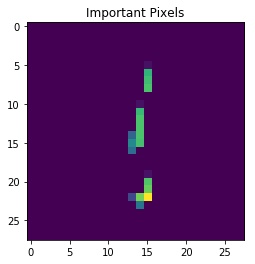

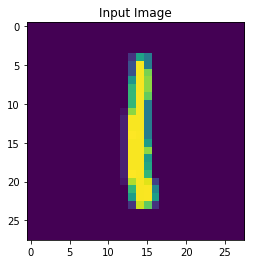

In [15]:
analyze_representative_v2(model, representatives[1])

Max Logit:
Value = 8.41, Index = 2

Most Important Rule:
Value = 3.29, Index = 5

Most Important Membership Functions:
Value = 0.65, Index = 9249
Value = 0.63, Index = 7007
Value = 0.62, Index = 9281
Value = 0.61, Index = 9265
Value = 0.59, Index = 9297
Value = 0.57, Index = 2001
Value = 0.56, Index = 2071
Value = 0.56, Index = 9473
Value = 0.56, Index = 7292
Value = 0.56, Index = 8159



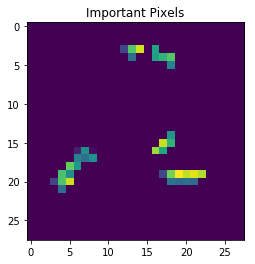

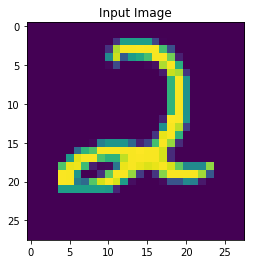

In [16]:
analyze_representative_v2(model, representatives[2])

Max Logit:
Value = 9.42, Index = 3

Most Important Rule:
Value = 2.63, Index = 7

Most Important Membership Functions:
Value = 0.60, Index = 6945
Value = 0.59, Index = 1980
Value = 0.59, Index = 1996
Value = 0.59, Index = 3249
Value = 0.59, Index = 1964
Value = 0.58, Index = 6929
Value = 0.57, Index = 10385
Value = 0.57, Index = 6961
Value = 0.57, Index = 10433
Value = 0.56, Index = 2849



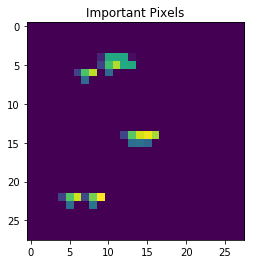

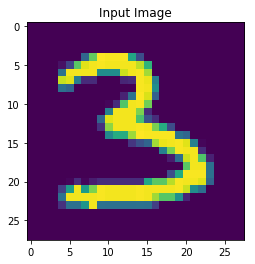

In [17]:
analyze_representative_v2(model, representatives[3])

Max Logit:
Value = 7.03, Index = 4

Most Important Rule:
Value = 4.55, Index = 3

Most Important Membership Functions:
Value = 0.64, Index = 7441
Value = 0.61, Index = 7729
Value = 0.59, Index = 7745
Value = 0.58, Index = 7809
Value = 0.57, Index = 8869
Value = 0.57, Index = 8421
Value = 0.56, Index = 7525
Value = 0.56, Index = 7761
Value = 0.55, Index = 7973
Value = 0.55, Index = 7425



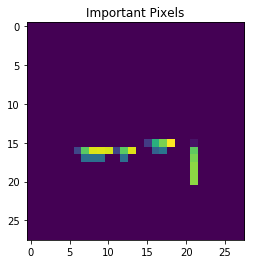

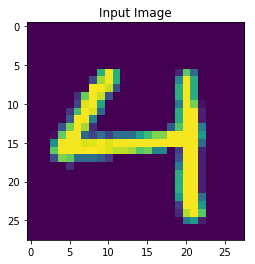

In [18]:
analyze_representative_v2(model, representatives[4])

Max Logit:
Value = 7.74, Index = 5

Most Important Rule:
Value = 3.36, Index = 0

Most Important Membership Functions:
Value = 0.63, Index = 4273
Value = 0.63, Index = 4321
Value = 0.62, Index = 4337
Value = 0.61, Index = 4257
Value = 0.61, Index = 4353
Value = 0.61, Index = 4289
Value = 0.60, Index = 4305
Value = 0.59, Index = 7761
Value = 0.59, Index = 6492
Value = 0.58, Index = 2476



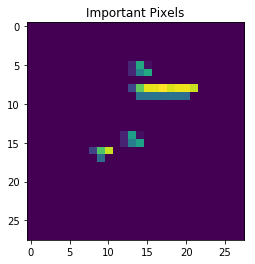

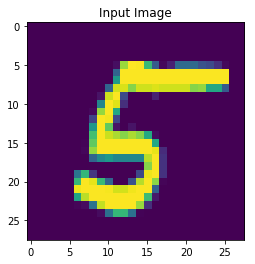

In [19]:
analyze_representative_v2(model, representatives[5])

Max Logit:
Value = 8.32, Index = 6

Most Important Rule:
Value = 3.04, Index = 1

Most Important Membership Functions:
Value = 0.63, Index = 10081
Value = 0.62, Index = 10065
Value = 0.58, Index = 5692
Value = 0.57, Index = 10097
Value = 0.56, Index = 5676
Value = 0.55, Index = 9601
Value = 0.55, Index = 9585
Value = 0.55, Index = 9617
Value = 0.54, Index = 5708
Value = 0.54, Index = 10049



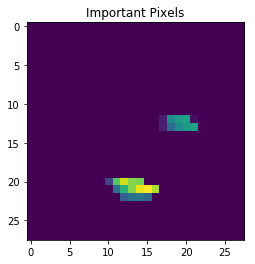

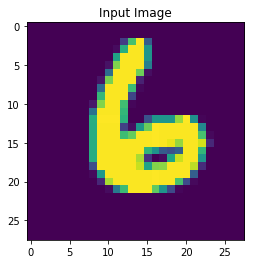

In [20]:
analyze_representative_v2(model, representatives[6])

Max Logit:
Value = 8.80, Index = 7

Most Important Rule:
Value = 2.71, Index = 4

Most Important Membership Functions:
Value = 0.63, Index = 5969
Value = 0.61, Index = 5985
Value = 0.60, Index = 5473
Value = 0.58, Index = 6017
Value = 0.57, Index = 5953
Value = 0.57, Index = 4620
Value = 0.55, Index = 6001
Value = 0.55, Index = 4684
Value = 0.55, Index = 6033
Value = 0.54, Index = 11441



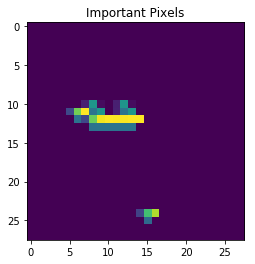

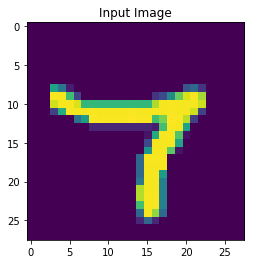

In [21]:
analyze_representative_v2(model, representatives[7])

Max Logit:
Value = 8.08, Index = 8

Most Important Rule:
Value = 3.27, Index = 1

Most Important Membership Functions:
Value = 0.68, Index = 6111
Value = 0.64, Index = 9215
Value = 0.64, Index = 6543
Value = 0.62, Index = 7375
Value = 0.62, Index = 7807
Value = 0.62, Index = 8239
Value = 0.62, Index = 9103
Value = 0.61, Index = 7870
Value = 0.61, Index = 6014
Value = 0.61, Index = 5550



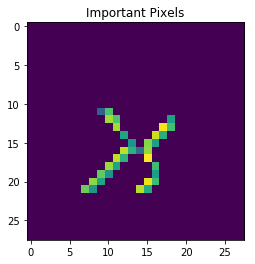

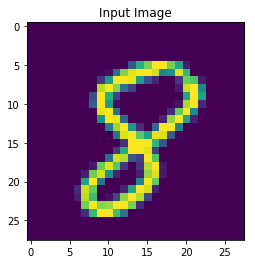

In [22]:
analyze_representative_v2(model, representatives[8])

Max Logit:
Value = 7.12, Index = 9

Most Important Rule:
Value = 2.90, Index = 2

Most Important Membership Functions:
Value = 0.65, Index = 3415
Value = 0.61, Index = 3359
Value = 0.60, Index = 5535
Value = 0.58, Index = 7377
Value = 0.58, Index = 4207
Value = 0.58, Index = 7329
Value = 0.58, Index = 3791
Value = 0.58, Index = 3857
Value = 0.57, Index = 3841
Value = 0.56, Index = 2956



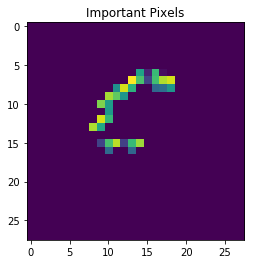

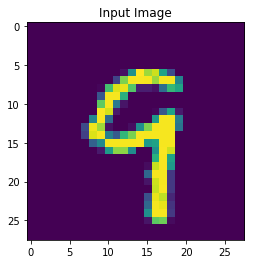

In [23]:
analyze_representative_v2(model, representatives[9])